# Transfer Learning

## Imports

In [1]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import random
import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50

In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Read Image Data

In [3]:
#Set data directory
data_dir = pathlib.Path('./data')

In [4]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print('# of Images found: ' + str(image_count))

# of Images found: 2527


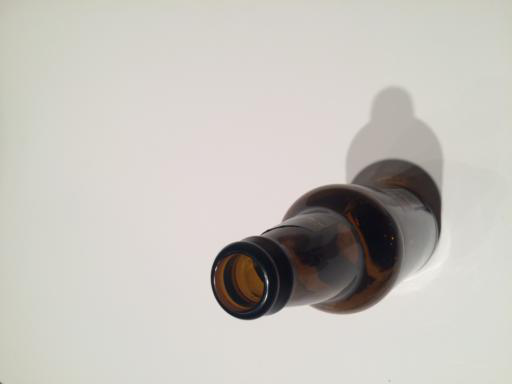

In [5]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

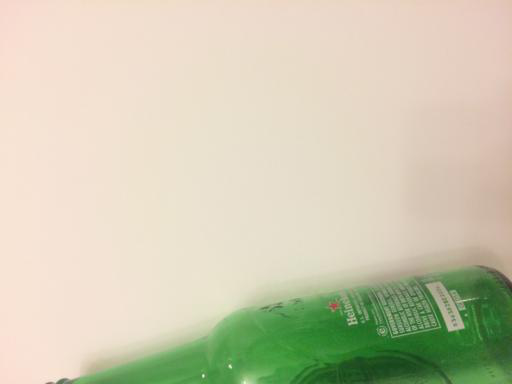

In [6]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [7]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

In [8]:
# clear images folder, if already exist
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [9]:
# define split method
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Copying files: 2527 files [00:13, 193.02 files/s]


Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


In [10]:
#Show names of the found classes
class_names = train_ds.class_names
num_classes = len(class_names)

print('The following classes were found: '+ str(class_names))

The following claases were foung: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Standardize the data

In [11]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.078431375 1.0


## Cache dataset

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define the Model

In [16]:
# Load the pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 512, 3))

# Freeze the layers
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Add a new layer
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [17]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5


c:\Users\Felix\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 [==============================] - 34s 469ms/step - loss: 0.9501 - accuracy: 0.6444 - val_loss: 0.6656 - val_accuracy: 0.7371
Epoch 2/5
64/64 [==============================] - 29s 454ms/step - loss: 0.5054 - accuracy: 0.8380 - val_loss: 0.5536 - val_accuracy: 0.7809
Epoch 3/5
64/64 [==============================] - 29s 455ms/step - loss: 0.3980 - accuracy: 0.8821 - val_loss: 0.5166 - val_accuracy: 0.8327
Epoch 4/5
64/64 [==============================] - 29s 455ms/step - loss: 0.3368 - accuracy: 0.8980 - val_loss: 0.5015 - val_accuracy: 0.8088
Epoch 5/5
64/64 [==============================] - 29s 455ms/step - loss: 0.2852 - accuracy: 0.9198 - val_loss: 0.4554 - val_accuracy: 0.8526


In [19]:
history = history.history

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 390, 518, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 192, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
date = datetime.today().strftime("%Y-%m-%d_%H-%M")

## Export Model

In [22]:
# set current datetime
date = datetime.today().strftime("%Y-%m-%d_%H-%M")

In [24]:
# [Optional]
# save as tflite model, for later tflite deployment
# Convert the model.
convert_model = False

if convert_model:
      with open("./models/trash_classes.txt", "w") as f:
            for cls in class_names:
                  f.write(cls + "\n")
      
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/transfer_model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpk78azg8x\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpk78azg8x\assets


In [25]:
# [Optional]
# save model
save_model = False
if save_model:      
      model.save(f'./models/transfer_model_{date}')

INFO:tensorflow:Assets written to: ./models/transfer_model_2023-02-24_15-14\assets


INFO:tensorflow:Assets written to: ./models/transfer_model_2023-02-24_15-14\assets


In [26]:
# [Optional]
#export training history
save = False

if save:
    np.save(f'./models/transfer_model_{date}_history.npy',history)

In [27]:
# [Optional]
#import previos training history
load = False
hist_dir = f'./models/transfer_model_{date}_history.npy'

if load:
    history=np.load(hist_dir,allow_pickle='TRUE').item()

## Show Model performance

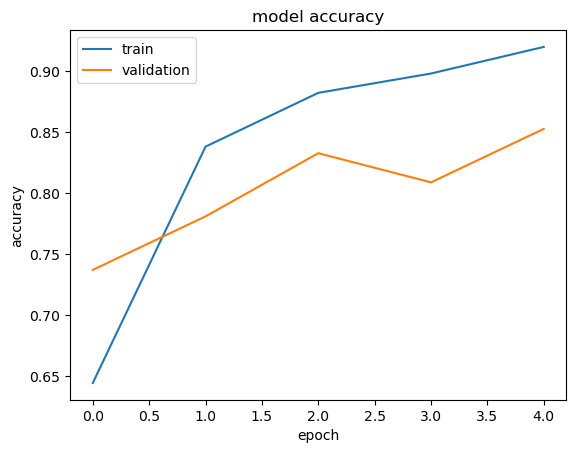

In [28]:
# plot accuracy

save_accuracy_img = False

def plot_history_acc(history):
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if save_accuracy_img:
        plt.savefig('transfer_history_acc.png')
    
plot_history_acc(history)


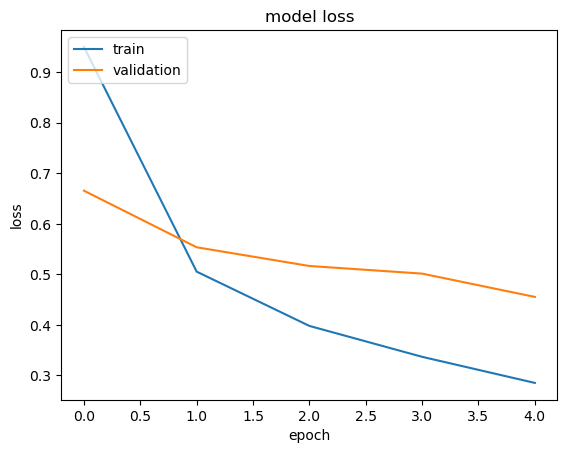

In [29]:
# plot model loss

save_loss_img = False

def plot_history_loss(history):
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if save_loss_img:
        plt.savefig('transfer_history_loss.png')
    
plot_history_loss(history)

## Classify Images

In [30]:
# classify single test image

img_dir = "./images/test/plastic/plastic49.jpg"
img = tf.keras.utils.load_img(img_dir)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )


1/1 [==============================] - 1s 747ms/step


1/1 [==============================] - 0s 20ms/step


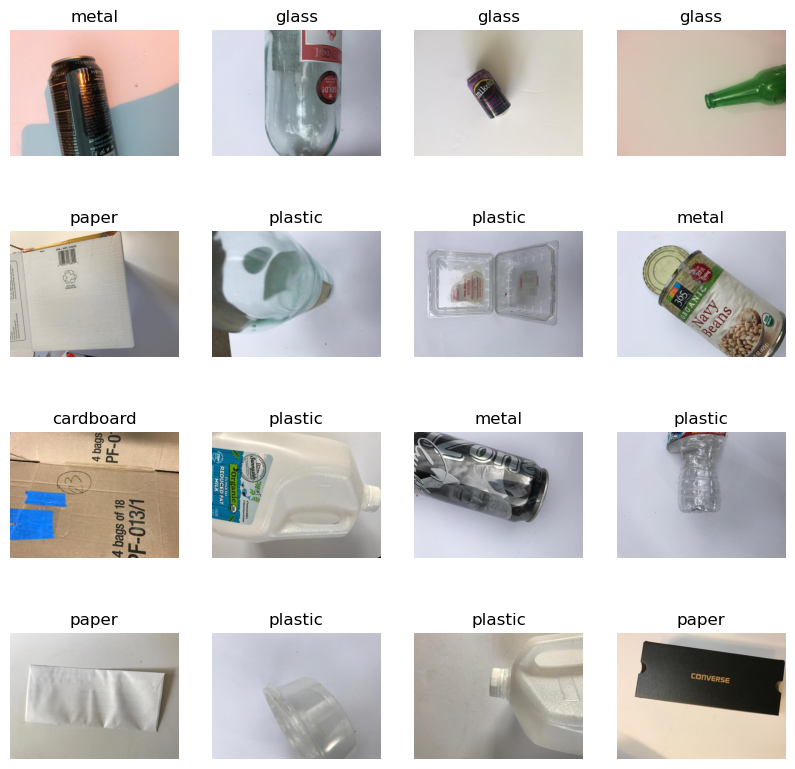

In [31]:
# show classifiaction of random test data

save_test_img = False

# read all test data
test_dir = "./images/test/"
test_files = glob.glob(test_dir + '/**/*', recursive = True)
random_test = random.sample(test_files,16) # select random sample

# plot predictions
plt.figure(figsize=(10, 10))
for i,image in enumerate(random_test):
    img = tf.keras.utils.load_img(image)
    img_array = tf.keras.utils.img_to_array(img) #
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # predict for sample image
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")
    
    if save_test_img:
        plt.savefig('transfer_test_sample.png')